<a href="https://colab.research.google.com/github/100495982/ML_G84_Grupo2/blob/main/primera_pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Primera Práctica**

**Autores:**


---


Luis Enrique Valero Montero - Gr. 85 - 100495982

Isabelle Borgstedt - Gr. 84 - 100559990

# EDA Simplificado

Things to add to the EDA:
- Distribution graphs
- Outlier detection and analysis
- Covariance
- Median, min, max, and average of important attributes

We can always keep adding more to this later.

In [ ]:
import pandas as pd
from tabulate import tabulate
df = pd.read_csv("attrition_availabledata_09.csv")

# ¿Cuántas variables e instancias hay?
print("Hay " + str(df.shape[0]) + " instancias y " + str(df.shape[1]) + " variables.")
print("-------------------------------------------------------------------------------------------------------------------------------------")

# ¿Qué variables son categóricas/ordinales/númericas?
cat_var = df.select_dtypes(include=['object']).columns.tolist()

def ordinales_o_numericas(df, threshold=5):
  num_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
  ord_var = []

  for col in num_var:
    unique_values = df[col].nunique()
    if unique_values <= threshold:
      ord_var.append(col)
    num_var = [x for x in num_var if x not in ord_var]
  return num_var, ord_var

print("Variables categóricas: ", cat_var)
print("Variables ordinales: ", ordinales_o_numericas(df)[1])
print("Variables numéricas: ", ordinales_o_numericas(df)[0])
print("-------------------------------------------------------------------------------------------------------------------------------------")

#corr_matrix = df.corr()
#print("Matriz de correlación: ")
#print(corr_matrix)
#print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Hay variables categóricas con alta cardinalidad?
def cardinalidad(df):
  cat_var = df.select_dtypes(include=['object']).columns.tolist()
  cardinalidad = {col: df[col].nunique() for col in cat_var}
  cardinalidad_df = pd.DataFrame(list(cardinalidad.items()), columns=['Variable', 'Unique Values'])
  cardinalidad_df = cardinalidad_df.sort_values(by="Unique Values", ascending=False)
  return cardinalidad_df

print("Variables con alta cardinalidad: ")
cardinalidad_df = cardinalidad(df)
print(cardinalidad_df)
print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Qué variables tienen valores faltantes y cuántos?
def faltantes(df):
  datos_faltantes = df.isnull().sum()
  datos_faltantes = datos_faltantes[datos_faltantes > 0]
  faltantes_df = pd.DataFrame({
      "Variable:": datos_faltantes.index,
      "Valores faltantes:": datos_faltantes.values,
      "Porcentaje faltantes:": datos_faltantes.values / len(df) * 100
  })
  faltantes_df = faltantes_df.sort_values(by="Porcentaje faltantes:", ascending=False)
  return faltantes_df

print("Variables con valores faltantes: ")
faltantes_df = faltantes(df)
print(faltantes_df)
print("-------------------------------------------------------------------------------------------------------------------------------------")

# ¿Hay columnas constantes o columnas de ID?
def constantes(df):
  constantes = []
  for col in df.columns:
    if df[col].nunique() == 1:
      constantes.append(col)
  return constantes

print("Columnas constantes: ", constantes(df))

def id(df):
  id_cols = []
  for col in df.columns:
    if df[col].nunique() == len(df):
      id_cols.append(col)
  return id_cols

print("Columnas de ID: ", id(df))
print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Se trata de un problema de regresión o clasificación?
print("Se trata de un problema de clasificación porque el attributo'Attrition' tiene dos posibles valores categoricos discretos: Sí o No.")
print("-------------------------------------------------------------------------------------------------------------------------------------")


# Si es clasificación, ¿está desbalanceado?
print(df["Attrition"].value_counts(normalize=True))
print("Está desbalanceado.")
print("-------------------------------------------------------------------------------------------------------------------------------------")


# Definir variables numéricas
numerical_vars, ordinal_vars = ordinales_o_numericas(df)

print("Estadísticas descriptivas para las variables numéricas:")
df_num_desc = df[numerical_vars].describe().transpose().round(2)  # Transpose for readability & round to 2 decimals
df_num_desc.insert(0, "Variable", df_num_desc.index)  # Add column for variable names
print(tabulate(df_num_desc, headers='keys', tablefmt='pretty', showindex=False))  # Print as a formatted table


print("Análisis descriptivo para las variables categóricas:")
for col in cat_var:
    print(f"\nDistribución de {col}:")
    df_cat = df[col].value_counts(normalize=True).mul(100).round(2).reset_index()  # Round to 2 decimal places
    df_cat.columns = [col, 'Percentage']
    print(tabulate(df_cat, headers='keys', tablefmt='pretty', showindex=False))


Hay 2940 instancias y 31 variables.
-------------------------------------------------------------------------------------------------------------------------------------
Variables categóricas:  ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Variables ordinales:  ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Education', 'EmployeeCount', 'JobLevel', 'StandardHours', 'StockOptionLevel']
Variables numéricas:  ['hrs', 'absences', 'Age', 'DistanceFromHome', 'EmployeeID', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
-------------------------------------------------------------------------------------------------------------------------------------
Variables con alta cardinalidad: 
         Variable  Unique Values
4         JobRole            

Vamos a encontrar "outliers" para determinar las mejores opciones para escalado y imputación.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Detecting Outliers using Z-Score
def zscore_outliers(df, threshold=3):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outliers_list = []  # Store outliers in a list

    for col in numerical_cols:
        z_scores = zscore(df[col].dropna())  # Calculate Z-scores
        outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
        outlier_values = df[col].iloc[outlier_indices]
        for idx, value in zip(outlier_indices, outlier_values):
            outliers_list.append({"Column": col, "Outlier Index": idx, "Z-Score": z_scores[idx]})

    outliers = pd.DataFrame(outliers_list)
    return outliers

# Detecting Outliers using IQR (Interquartile Range)
def iqr_outliers(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outliers_list = []  # Store outliers in a list

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_values = df[col].loc[outlier_indices]

        for idx, value in zip(outlier_indices, outlier_values):
            outliers_list.append({"Column": col, "Outlier Index": idx, "IQR Method": value})

    outliers = pd.DataFrame(outliers_list)
    return outliers

# Find outliers using Z-Score
outliers_zscore = zscore_outliers(df)
print("\nOutliers using Z-Score:")
print(outliers_zscore)

# Find outliers using IQR Method
outliers_iqr = iqr_outliers(df)
print("\nOutliers using IQR Method:")
print(outliers_iqr)



Outliers using Z-Score:
                   Column  Outlier Index   Z-Score
0       TotalWorkingYears             50  3.248904
1       TotalWorkingYears            185  3.122043
2       TotalWorkingYears            248  3.122043
3       TotalWorkingYears            292  3.122043
4       TotalWorkingYears            386  3.122043
..                    ...            ...       ...
168  YearsWithCurrManager           2293  3.554717
169  YearsWithCurrManager           2414  3.554717
170  YearsWithCurrManager           2424  3.554717
171  YearsWithCurrManager           2583  3.001849
172  YearsWithCurrManager           2731  3.001849

[173 rows x 3 columns]

Outliers using IQR Method:
                    Column  Outlier Index  IQR Method
0                      hrs             12   10.666170
1                      hrs             25   10.389476
2                      hrs             51   10.433987
3                      hrs             64   10.907255
4                      hrs            214

# Preproceso

In [ ]:
# Quitar los parámetros constantes y únicos
constantes_cols = constantes(df)
id_cols = id(df)

# Combinar las columnas para dejar y dejarlas
columns_to_drop = constantes_cols + id_cols

# Eliminar las columnas
df = df.drop(columns=columns_to_drop)

# Imprimir las columnas que se quedan
print("Remaining columns: ", df.columns)

Remaining columns:  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition'],
      dtype='object')


# Evaluacion de Rendimiento Futuro

Aquí estamos separando los datos con Holdout: 2/3 train y 1/3 test. Debemos garantizar que los datos para "test" solo son usados para el rendimiento final.

Es importante que mantengamos el balance cuando dividimos los datos: 83.9% "no" y 16.1% "yes".

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report

# Defining target variable and features
target = "Attrition"
X = df.drop(columns=[target])
y = df[target]

# Convert categorical variables into numerical values using One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)  # Avoids multicollinearity by dropping one category per feature

# Perform the outer train-test split (stratify to maintain class proportions)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=1/3, stratify=y, random_state=559990)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Evaluation Function (defined but not used yet)
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a model using Balanced Accuracy, TPR, TNR, and a confusion matrix.
    """
    y_pred = model.predict(X_test)  # Get predictions

    # Compute metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    overall_acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Extract TPR (Sensitivity) and TNR (Specificity)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # Sensitivity (Recall for positive class)
    tnr = tn / (tn + fp)  # Specificity

    # Print results
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Overall Accuracy: {overall_acc:.4f}")
    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print(f"True Negative Rate (TNR): {tnr:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Training set: (1960, 40), Test set: (980, 40)


# Metodos Basicos: KNN y Trees

KNN:

Trees:

Vamos a empezar con los métodos de escalado y imputación. Elegimos imputación usando la mediana y escalado usando RobustScaler porque tenemos outliers. También medimos el tiempo de entrenar el modelo.

In [ ]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Imputación
num_imputer = SimpleImputer(strategy="median")  # Mediana porque tenemos outliers
X_encoded.iloc[:, :] = num_imputer.fit_transform(X_encoded)

# Escalado
scaler = RobustScaler()  # Robust porque tenemos outliers
X_scaled = scaler.fit_transform(X_encoded)

# Convertirse en DataFrame después del escalado
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
df_processed = X_scaled.copy()

# Split the data into training and testing sets (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=1/3, stratify=y, random_state=559990)

# Train the Decision Tree with default hyperparameters and measure the training time
start_time = time.time()  # Start timer
model = DecisionTreeClassifier(random_state=559990)
model.fit(X_train, y_train)
end_time = time.time()  # End timer

# El tiempo de entrenar
training_time = end_time - start_time
print(f"Training time (default hyperparameters): {training_time:.4f} seconds")

# Evaluar el modelo
evaluate_model(model, X_test, y_test)


Training time (default hyperparameters): 0.0259 seconds
Balanced Accuracy: 0.8009
Overall Accuracy: 0.8847
True Positive Rate (TPR): 0.6772
True Negative Rate (TNR): 0.9246

Confusion Matrix:
[[760  62]
 [ 51 107]]

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.92      0.93       822
         Yes       0.63      0.68      0.65       158

    accuracy                           0.88       980
   macro avg       0.79      0.80      0.79       980
weighted avg       0.89      0.88      0.89       980



Esta matrix de confusión muestra "overall accuracy" TPR y TNR. Es claro que "overall accuracy" es engañoso en este caso porque tenemos datos desbalanceados. Sin embargo, podemos ver que "balanced accuracy" provee una una fórmula más representativa porque da el mismo peso a los dos categorías de "attrition". Podemos notar la diferencia entre los porcentajes de TPR y TNR. Los datos demuestran que el rendimiento del modelo es mucho mejor para los casos de "No" que los casos de "Yes".



Entonces, vamos a realizar HPO usando GridSearch.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar a DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=559990)

# Realizar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
start_time = time.time()  # Start timer
grid_search.fit(X_train, y_train)
end_time = time.time()  # End timer

# Medir el tiempo del entrenamiento para GridSearchCV
training_time_tuned = end_time - start_time
print(f"Training time (hyperparameter tuning): {training_time_tuned:.4f} seconds")

# Mejores hiperparámetros
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluar el modelo ajustado
y_pred_tuned = grid_search.best_estimator_.predict(X_test)
print("Classification Report (Tuned Hyperparameters):\n", classification_report(y_test, y_pred_tuned))


Training time (hyperparameter tuning): 13.7244 seconds
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report (Tuned Hyperparameters):
               precision    recall  f1-score   support

          No       0.94      0.92      0.93       822
         Yes       0.63      0.68      0.65       158

    accuracy                           0.88       980
   macro avg       0.79      0.80      0.79       980
weighted avg       0.89      0.88      0.89       980



Vamos a mostrar las diferencias entre los hiperparámetros con gráficos.

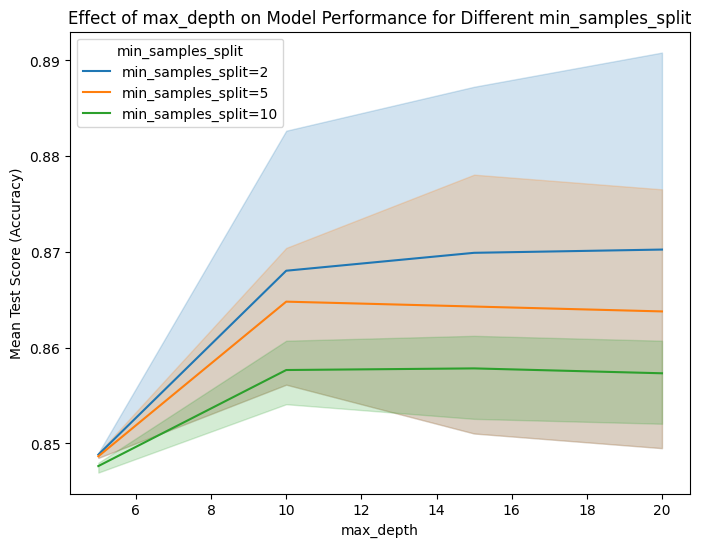

In [42]:
# Line plot for max_depth vs accuracy for different min_samples_split values
plt.figure(figsize=(8, 6))
for split_value in results['param_min_samples_split'].unique():
    sub_results = results[results['param_min_samples_split'] == split_value]
    sns.lineplot(data=sub_results, x='param_max_depth', y='mean_test_score', label=f"min_samples_split={split_value}")
plt.title("Effect of max_depth on Model Performance for Different min_samples_split")
plt.xlabel('max_depth')
plt.ylabel('Mean Test Score (Accuracy)')
plt.legend(title='min_samples_split')
plt.show()

# Modelos Lineales y SVMs

# Resultados y Modelo Final

# Tarea de Eleccion Abierta

Random Forest:

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming df is your DataFrame

# Filter out only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Select the feature variables (X) and target variable (y)
X = df[numerical_columns]
y = df['Attrition']  # 'Attrition' is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=559990)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(random_state=559990)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance (optional) to see which numerical features are most important
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_df)


Classification Report:
               precision    recall  f1-score   support

          No       0.93      1.00      0.96       474
         Yes       1.00      0.69      0.82       114

    accuracy                           0.94       588
   macro avg       0.97      0.85      0.89       588
weighted avg       0.94      0.94      0.94       588


Feature Importances:
                     Feature  Importance
0                       hrs    0.124215
11            MonthlyIncome    0.092147
7                       Age    0.082528
15        TotalWorkingYears    0.079670
17           YearsAtCompany    0.065831
8          DistanceFromHome    0.056164
13        PercentSalaryHike    0.053072
12       NumCompaniesWorked    0.052133
19     YearsWithCurrManager    0.047774
4   EnvironmentSatisfaction    0.045771
1                  absences    0.038490
6           WorkLifeBalance    0.036229
16    TrainingTimesLastYear    0.034388
9                 Education    0.034039
5           JobSatisfactio